In [2]:
import os 
import sys

import torch
from torch import nn
from torch.optim.adam import Adam
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

from conditional_rate_matching.configs.config_crm import Config,NistConfig
from conditional_rate_matching.configs.config_files import ExperimentFiles
from conditional_rate_matching.data.dataloaders_utils import get_dataloaders
from conditional_rate_matching.models.metrics.crm_metrics_utils import log_metrics

from conditional_rate_matching.models.generative_models.crm import (
    CRM,
    ConditionalBackwardRate,
    ClassificationBackwardRate,
    sample_x,
    conditional_transition_rate,
    uniform_pair_x0_x1
)

In [9]:
from conditional_rate_matching.models.trainers.crm_trainer import train_step,save_results

In [14]:
# Files to save the experiments
experiment_files = ExperimentFiles(experiment_name="crm",
                                   experiment_type="dirichlet_K",
                                   experiment_indentifier="save_and_load",
                                   delete=True)
experiment_files.create_directories()

# Configuration
config = Config(number_of_epochs=10,number_of_states=2)
#config = NistConfig(number_of_epochs=10,hidden_dim=300,batch_size=128,sample_size=2000)

#=====================================================
# DATA STUFF
#=====================================================

dataloader_0, dataloader_1 = get_dataloaders(config)

#=========================================================
# Initialize
#=========================================================

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
config.loss = "classifier"

if config.loss == "naive":
    model = ConditionalBackwardRate(config, device)
    loss_fn = nn.MSELoss()
elif config.loss == "classifier":
    model = ClassificationBackwardRate(config, device).to(device)
    loss_fn = nn.CrossEntropyLoss()

# all model
crm = CRM(config,experiment_files,dataloader_0,dataloader_1,model)

Epoch 5, Loss: 0.5203:  40%|████████████████████████▊                                     | 4/10 [00:06<00:07,  1.22s/it]
0it [00:00, ?it/s]c:\users\cesar\desktop\projects\diffusivegenerativemodelling\codes\conditional_rate_matching\src\conditional_rate_matching\models\temporal_networks\backward_rates\crm_backward_rates.py:112: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rate_probabilities = softmax(rate_logits)
20it [00:00, 510.06it/s]


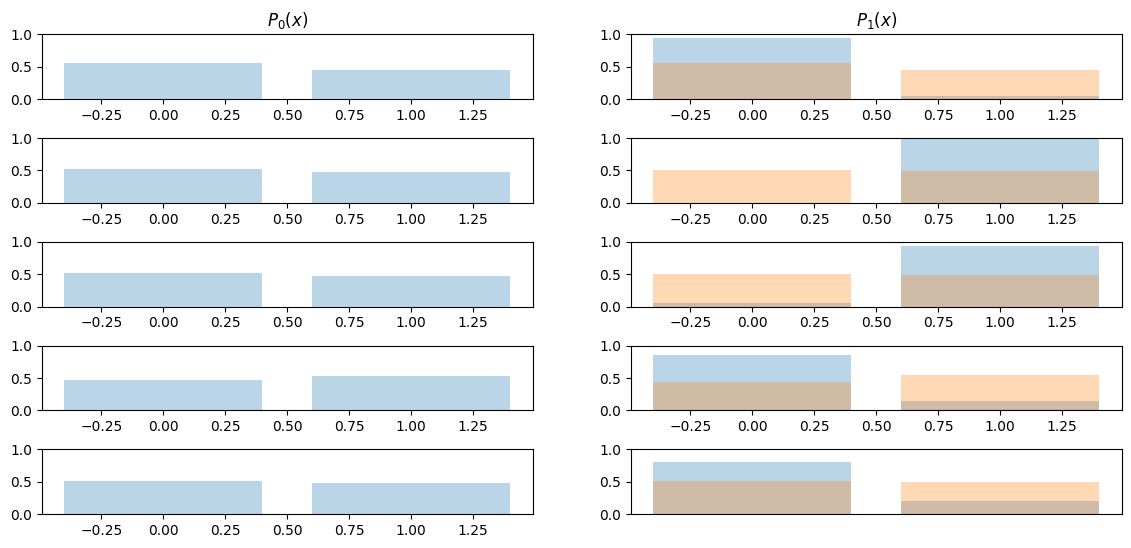

Epoch 10, Loss: 0.4261:  90%|██████████████████████████████████████████████████████▉      | 9/10 [00:13<00:01,  1.35s/it]
20it [00:00, 536.77it/s]


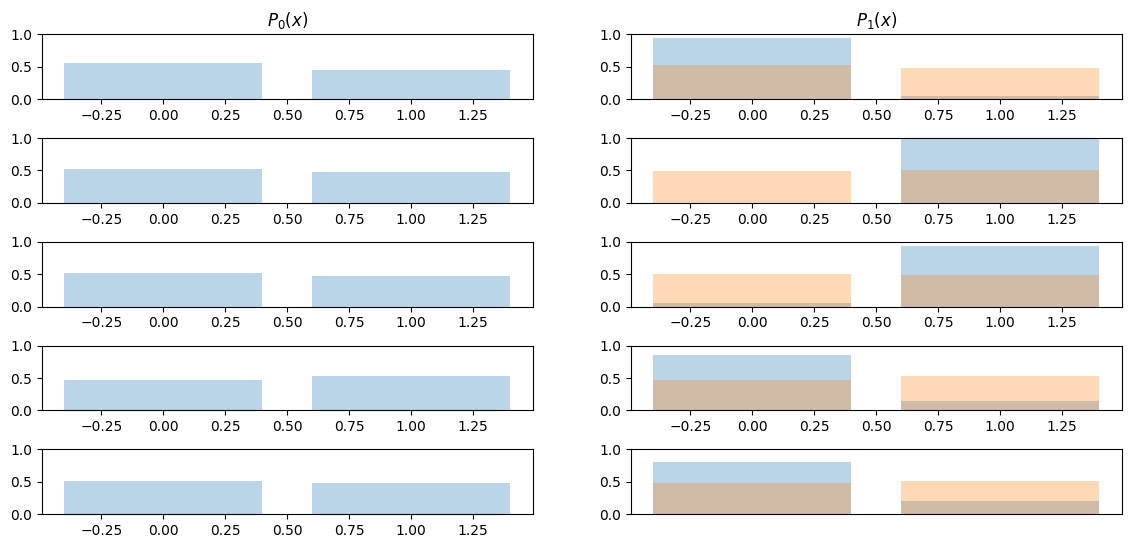

Epoch 10, Loss: 0.4261: 100%|████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.47s/it]


In [15]:
#=========================================================
# Training
#=========================================================
writer = SummaryWriter(experiment_files.tensorboard_path)
optimizer = Adam(model.parameters(), lr=config.learning_rate)
tqdm_object = tqdm(range(config.number_of_epochs))

number_of_training_steps = 0
for epoch in tqdm_object:
    for batch_1, batch_0 in zip(dataloader_1, dataloader_0):

        loss = train_step(config,model,loss_fn,batch_1,batch_0,optimizer,device)
        number_of_training_steps += 1

        writer.add_scalar('training loss', loss.item(), number_of_training_steps)

        tqdm_object.set_description(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")
        tqdm_object.refresh()  # to show immediately the update

    if (epoch + 1) % config.save_model_epochs == 0:
        results = save_results(crm, experiment_files, epoch + 1, checkpoint=True)

    if (epoch + 1) % config.save_metric_epochs == 0:
        all_metrics = log_metrics(crm=crm, epoch=epoch + 1, writer=writer)

writer.close()